In [132]:
import psycopg2
import pandas as pd
import numpy as np
import os
import json
import pickle

from sqlalchemy import create_engine

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer

import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("darkgrid")

In [133]:
with open('config.json') as file:
    config = json.load(file)
    host = config['host']
    database = config['database']
    user = config['user']
    password = config['password']
    
    engine = create_engine(f'postgresql://{user}:{password}@{host}:5432/{database}')

In [162]:
with open("./fetch_data.sql", "r") as f:
    query = f.read()

df = pd.read_sql_query(query, engine)

In [107]:
df.head()

,hadm_id,diastolic_min,diastolic_mean,diastolic_max,systolic_min,systolic_mean,systolic_max,staph_sensitive_ratio,staph_intermediate_ratio,staph_resistant_ratio,...,pneumonia_diagnosis,uti_diagnosis,skin_infection_diagnosis,gi_infection_diagnosis,diabetes_diagnosis,cancer_diagnosis,lung_disease_diagnosis,immunodeficiency_diagnosis,kidney_disease_diagnosis,will_readmit_for_sepsis
0,100375,28.0,50.469388,62.0,77.0,98.571429,123.0,NaN,NaN,NaN,...,NaN,1.0,NaN,NaN,NaN,NaN,NaN,None,1.0,NaN
1,100969,51.0,71.054054,113.0,122.0,155.891892,213.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,1.0,NaN,1.0,None,NaN,NaN
2,101361,36.0,66.877551,111.0,73.0,117.602041,166.0,0.500,0.0,0.500,...,1.0,NaN,NaN,NaN,1.0,NaN,1.0,None,1.0,NaN
3,102203,52.0,69.851852,84.0,100.0,116.888889,129.0,0.625,0.0,0.375,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,1.0,NaN
4,103379,44.0,62.219178,151.0,77.0,111.328767,165.0,NaN,NaN,NaN,...,1.0,NaN,NaN,1.0,NaN,1.0,NaN,None,NaN,NaN


In [108]:
df.columns

Index(['hadm_id', 'diastolic_min', 'diastolic_mean', 'diastolic_max',
       'systolic_min', 'systolic_mean', 'systolic_max',
       'staph_sensitive_ratio', 'staph_intermediate_ratio',
       'staph_resistant_ratio', 'e_coli_sensitive_ratio',
       'e_coli_intermediate_ratio', 'e_coli_resistant_ratio',
       'strep_sensitive_ratio', 'strep_intermediate_ratio',
       'strep_resistant_ratio', 'min_temp', 'mean_temp', 'max_temp',
       'min_heart_rate', 'mean_heart_rate', 'max_heart_rate',
       'min_respiratory_rate', 'mean_respiratory_rate', 'max_respiratory_rate',
       'pneumonia_diagnosis', 'uti_diagnosis', 'skin_infection_diagnosis',
       'gi_infection_diagnosis', 'diabetes_diagnosis', 'cancer_diagnosis',
       'lung_disease_diagnosis', 'immunodeficiency_diagnosis',
       'kidney_disease_diagnosis', 'will_readmit_for_sepsis'],
      dtype='object')

In [109]:
df.describe()

,hadm_id,diastolic_min,diastolic_mean,diastolic_max,systolic_min,systolic_mean,systolic_max,staph_sensitive_ratio,staph_intermediate_ratio,staph_resistant_ratio,...,max_respiratory_rate,pneumonia_diagnosis,uti_diagnosis,skin_infection_diagnosis,gi_infection_diagnosis,diabetes_diagnosis,cancer_diagnosis,lung_disease_diagnosis,kidney_disease_diagnosis,will_readmit_for_sepsis
count,129.000000,125.000000,125.000000,125.000000,125.00000,125.000000,125.000000,20.000000,20.000000,20.000000,...,125.000000,34.0,27.0,3.0,7.0,48.0,56.0,64.0,61.0,5.0
mean,152343.441860,33.416000,58.651769,93.496000,73.34400,116.983697,248.272000,0.595982,0.010268,0.393750,...,32.760000,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
std,27858.788248,16.812622,11.321657,22.761606,33.91001,20.333707,1028.086575,0.200871,0.034187,0.194827,...,12.834807,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
min,100375.000000,0.000000,30.196078,45.000000,0.00000,70.600000,93.000000,0.375000,0.000000,0.000000,...,18.000000,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
25%,128293.000000,21.000000,51.458333,77.000000,55.00000,102.560852,139.000000,0.486111,0.000000,0.375000,...,25.000000,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
50%,157235.000000,37.000000,59.470588,91.000000,82.00000,116.066667,154.000000,0.500000,0.000000,0.472222,...,30.000000,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
75%,174739.000000,48.000000,66.930233,105.000000,93.00000,128.487395,178.000000,0.625000,0.000000,0.500000,...,37.000000,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
max,199395.000000,64.000000,90.131250,169.000000,143.00000,170.323308,11647.000000,1.000000,0.142857,0.625000,...,118.000000,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


In [117]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 129 entries, 0 to 128
Data columns (total 35 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   hadm_id                     129 non-null    float64
 1   diastolic_min               129 non-null    float64
 2   diastolic_mean              129 non-null    float64
 3   diastolic_max               129 non-null    float64
 4   systolic_min                129 non-null    float64
 5   systolic_mean               129 non-null    float64
 6   systolic_max                129 non-null    float64
 7   staph_sensitive_ratio       129 non-null    float64
 8   staph_intermediate_ratio    129 non-null    float64
 9   staph_resistant_ratio       129 non-null    float64
 10  e_coli_sensitive_ratio      129 non-null    float64
 11  e_coli_intermediate_ratio   129 non-null    float64
 12  e_coli_resistant_ratio      129 non-null    float64
 13  strep_sensitive_ratio       129 non

In [13]:
numeric_df = df.iloc[:, 1:25]
numeric_df['will_readmit_for_sepsis'] = df['will_readmit_for_sepsis']
categorical_df = df.iloc[:, 25:]

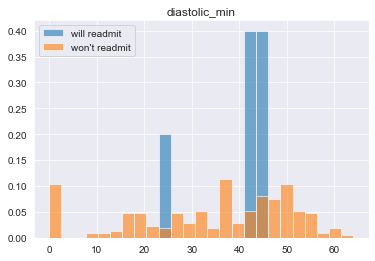

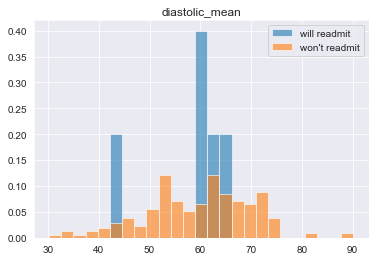

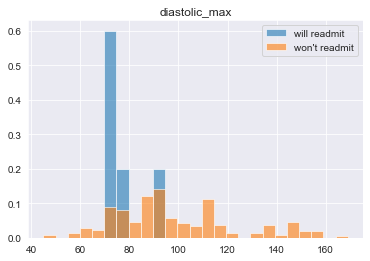

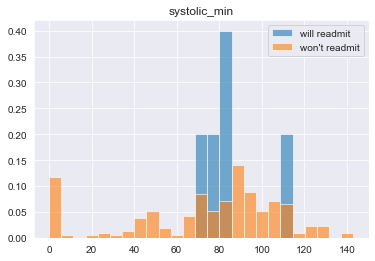

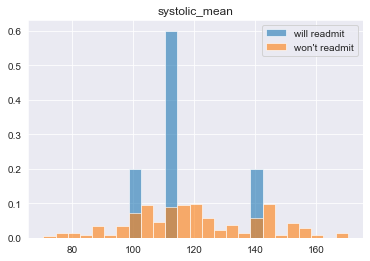

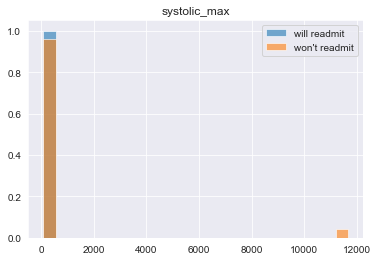

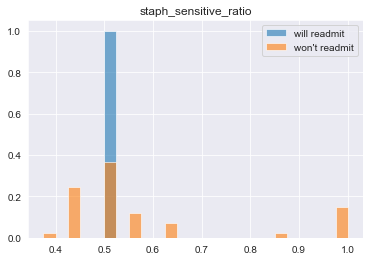

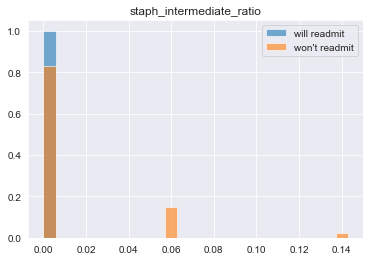

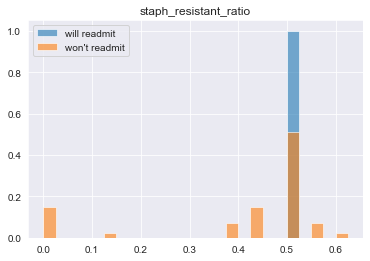

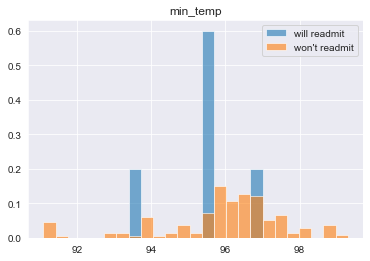

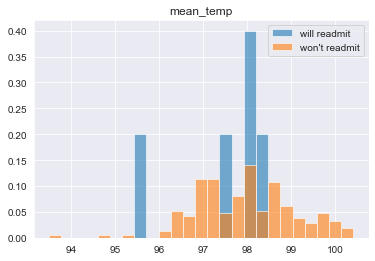

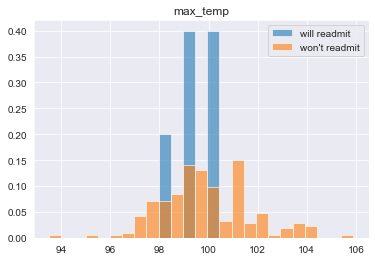

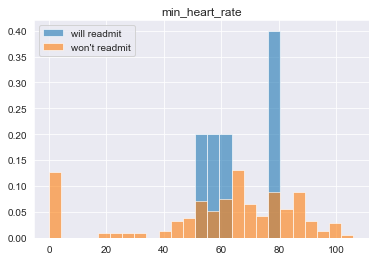

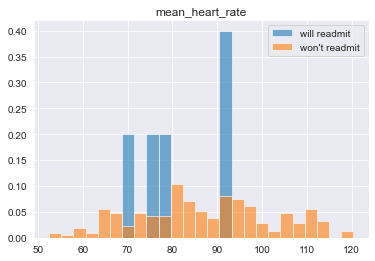

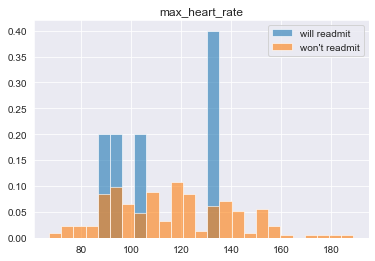

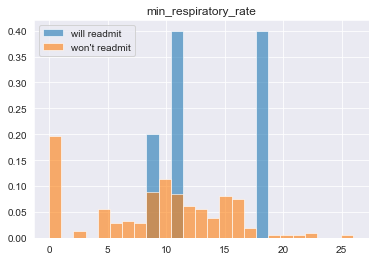

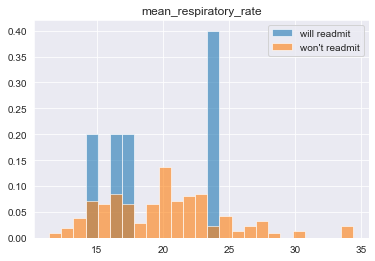

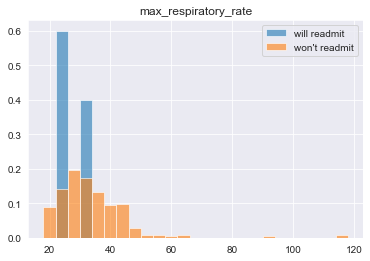

In [74]:
mask = (numeric_df['will_readmit_for_sepsis'] == 1)

hist_params = {
    "alpha": 0.6,
    "bins": 25,
}

for col in numeric_df:
    will = numeric_df[mask][col].dropna()
    wont = numeric_df[~mask][col].dropna()
    if (len(will) > 0 and len(wont) > 0):
        hist_range = (min(numeric_df[col].dropna()), max(numeric_df[col].dropna()))
        plt.hist(will, **hist_params, range=hist_range, label="will readmit", weights=[1/len(will)]*len(will))
        plt.hist(wont, **hist_params, range=hist_range, label="won't readmit", weights=[1/len(wont)]*len(wont))
        plt.title(col)
        plt.legend()
        plt.show()

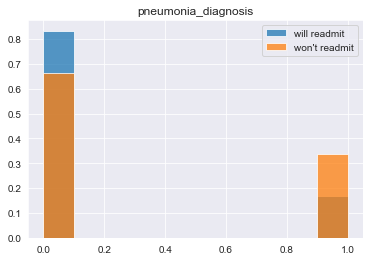

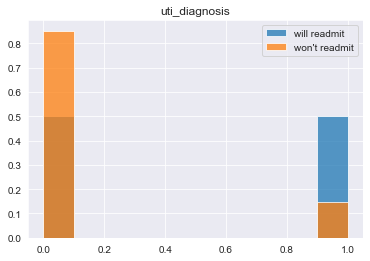

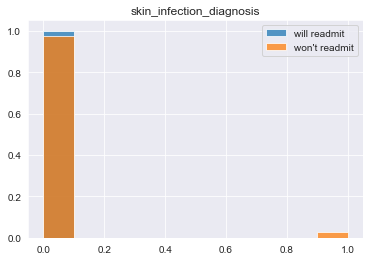

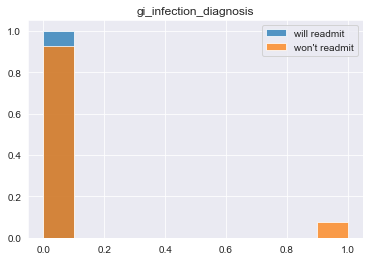

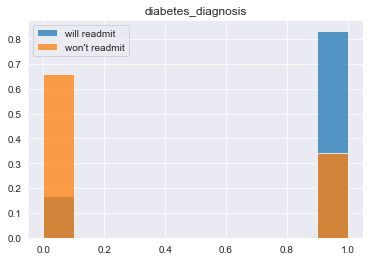

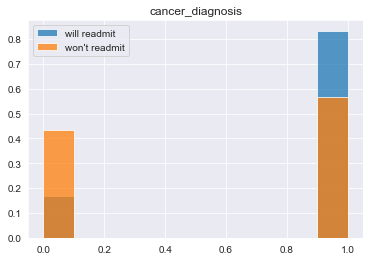

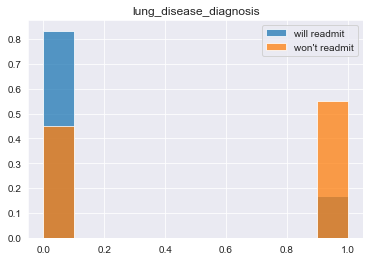

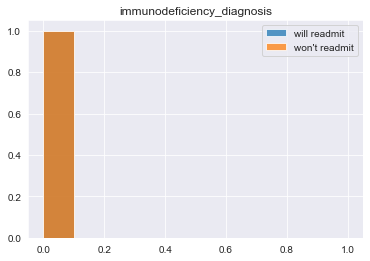

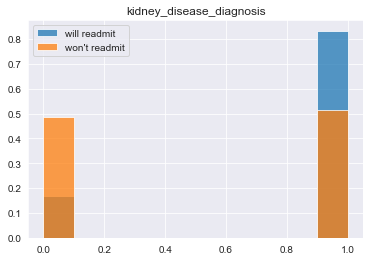

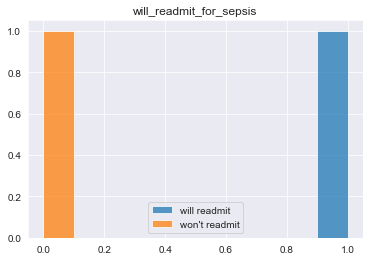

In [81]:
hist_params = {
    "range": (0, 1),
    "alpha": 0.75
}

for col in categorical_df:
    will = categorical_df[mask][col].fillna(0)
    wont = categorical_df[~mask][col].fillna(0)
    if (len(will) > 0 and len(wont) > 0):
        plt.hist(will, **hist_params, label="will readmit", weights=[1/len(will)]*len(will))
        plt.hist(wont, **hist_params, label="won't readmit", weights=[1/len(wont)]*len(wont))
        plt.title(col)
        plt.legend()
        plt.show()

In [163]:
na_cols = ['e_coli_sensitive_ratio',
       'e_coli_intermediate_ratio', 'e_coli_resistant_ratio',
       'strep_sensitive_ratio', 'strep_intermediate_ratio',
       'strep_resistant_ratio'
]

df[na_cols] = df[na_cols].fillna(0)

In [164]:
diagnosis_columns = df.filter(regex=".+_diagnosis").columns

df[diagnosis_columns] = df[diagnosis_columns].fillna(0)
df['will_readmit_for_sepsis'] = df['will_readmit_for_sepsis'].fillna(0)

In [165]:
columns = df.columns

imputer = SimpleImputer()

df = imputer.fit_transform(df)

df = pd.DataFrame(df, columns=columns)

In [166]:
df

,hadm_id,diastolic_min,diastolic_mean,diastolic_max,systolic_min,systolic_mean,systolic_max,staph_sensitive_ratio,staph_intermediate_ratio,staph_resistant_ratio,...,pneumonia_diagnosis,uti_diagnosis,skin_infection_diagnosis,gi_infection_diagnosis,diabetes_diagnosis,cancer_diagnosis,lung_disease_diagnosis,immunodeficiency_diagnosis,kidney_disease_diagnosis,will_readmit_for_sepsis
0,100375.0,28.0,50.469388,62.0,77.0,98.571429,123.0,0.595982,0.010268,0.39375,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,100969.0,51.0,71.054054,113.0,122.0,155.891892,213.0,0.595982,0.010268,0.39375,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
2,101361.0,36.0,66.877551,111.0,73.0,117.602041,166.0,0.500000,0.000000,0.50000,...,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
3,102203.0,52.0,69.851852,84.0,100.0,116.888889,129.0,0.625000,0.000000,0.37500,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,103379.0,44.0,62.219178,151.0,77.0,111.328767,165.0,0.595982,0.010268,0.39375,...,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
124,198330.0,50.0,68.513761,95.0,80.0,111.862385,157.0,1.000000,0.000000,0.00000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
125,198480.0,24.0,38.516667,58.0,46.0,113.033333,165.0,0.595982,0.010268,0.39375,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
126,198503.0,17.0,54.373626,91.0,42.0,98.963370,179.0,0.595982,0.010268,0.39375,...,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0
127,199207.0,33.0,54.702703,77.0,88.0,113.236842,137.0,0.595982,0.010268,0.39375,...,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0


In [167]:
pickle.dump(df, open("./app/data.pickle", "wb"))

In [147]:
df[df['staph_intermediate_ratio'] > 1]

,hadm_id,diastolic_min,diastolic_mean,diastolic_max,systolic_min,systolic_mean,systolic_max,staph_sensitive_ratio,staph_intermediate_ratio,staph_resistant_ratio,...,pneumonia_diagnosis,uti_diagnosis,skin_infection_diagnosis,gi_infection_diagnosis,diabetes_diagnosis,cancer_diagnosis,lung_disease_diagnosis,immunodeficiency_diagnosis,kidney_disease_diagnosis,will_readmit_for_sepsis
